# Getting Started guide for Anytime MA-BBOB Competition

This notebook is designed to guide you through the process of creating a submission for the GECCO competition on anytime algorithms for MA-BBOB. 
While this competition is built on the IOHprofiler suite, no prior knowledge of these tools is required. This notebook is standalone, so it will explain only the parts required for running and evaluating your algorithm. For more details on IOHprofiler, we refer to iohprofiler.github.io

This notebook is structured as follows:
- Installing the required dependencies
- Accessing the MA-BBOB problems
- Implementing your algorithm
- Logging performance data
- Analyzing the performance of your algorithms
- Comparing your algorithm to the provided baselines


## Step 1: Installing the required packages

For accessing the MA-BBOB generator, we need the IOHexperimenter package, available on pypi as 'ioh'. 

For the later processing of the benchmark data, we will use the newly released IOHinspector package. This can be cloned and installed from GitHub directly, or installed as 'iohinspector' from pypi.

We will now load these packages, as well as some default packages which we will use for the example algorithm

In [2]:
import iohinspector
import ioh
import numpy as np
import pandas as pd
import polars as pl
from tqdm import tqdm # optional, for progress bars
import os

## Step 2: Accessing the MA-BBOB problems

To access the MA-BBOB problems themselves, we use the IOHexperimenter. This can be done via `ioh.problem.ManyAffine`, which can either be instantiated using an instance number and problem dimensionality, or, for more direct control of the affine combination, using the location of the optimum, weigthing of the BBOB problems and their corresponding instances and finally the problem dimensionality. 

To allow for easy comparison with our baselines, we will use the provided files with full instance specifications, rather than the instance number approach. 

In [3]:
# Read in the instance specifications
weights = pd.read_csv("weights.csv", index_col=0)
iids = pd.read_csv("iids.csv", index_col=0)
opt_locs = pd.read_csv("opt_locs.csv", index_col=0)
print(len(iids))

1000


To illustrate the functionality of the returned problem, we start by creating the first instances of the problem in 2D. 

In [4]:
f = ioh.problem.ManyAffine(xopt = np.array(opt_locs.iloc[0])[:2], 
                                    weights = np.array(weights.iloc[0]),
                                    instances = np.array(iids.iloc[0], dtype=int), 
                                    n_variables = 2)

With this problem object, your algorithm can access important meta-data, such as the bounds and dimensionality 

In [5]:
f.bounds.lb, f.bounds.ub, f.meta_data.n_variables

(array([-5., -5.]), array([5., 5.]), 2)

For convenient processing / grouping, meta-data can also be modified after the problem has been loaded. This allows for example for the setting of custom problem and instance identifiers.

In [6]:
f.set_id(123)
f.set_instance(1)

## Step 3: Implementing your algorithm

To use IOHexperimenter-based problems, there are no real requirements on your algorithm, since the problem behaves just like a normal python function, returning the function value when called with a candidate solution. Here, we implement a simple random search to illustrate how your algorithm can benefit from the meta-data provided by the problem.

In [7]:
class RandomSearch:
    'Simple random search algorithm'
    def __init__(self, budget_factor: int):
        self.budget_factor: int = budget_factor
        
    def __call__(self, problem: ioh.problem.RealSingleObjective) -> None:
        'Evaluate the problem `budget_factor * DIM` times with a randomly generated solution'
        
        for _ in range(self.budget_factor * problem.meta_data.n_variables):
            # We can use the problems bounds accessor to get information about the problem bounds
            x = np.random.uniform(problem.bounds.lb, problem.bounds.ub)            
            problem(x)   

In [8]:
import numpy as np

class AdaptiveDE:
    def __init__(self, budget=10000, dim=10, pop_size=20):
        self.budget = budget
        self.dim = dim
        self.pop_size = pop_size

    def __call__(self, func):
        # Initialization
        population = np.random.uniform(func.bounds.lb, func.bounds.ub, size=(self.pop_size, self.dim))
        fitness = np.array([func(x) for x in population])
        self.budget -= self.pop_size

        self.f_opt = np.min(fitness)
        self.x_opt = population[np.argmin(fitness)]

        while self.budget > 0:
            for i in range(self.pop_size):
                # Mutation: DE/rand/1 - Simplified with dynamic F
                F = np.random.uniform(0.2, 0.8)  # Dynamic F
                indices = np.random.choice(self.pop_size, 3, replace=False)
                x_r1, x_r2, x_r3 = population[indices]
                mutant = x_r1 + F * (x_r2 - x_r3)
                mutant = np.clip(mutant, func.bounds.lb, func.bounds.ub)

                # Crossover - Simplified with dynamic CR
                CR = np.random.uniform(0.5, 1.0)  # Dynamic CR
                crossover_mask = np.random.rand(self.dim) < CR
                trial_vector = np.where(crossover_mask, mutant, population[i])

                # Selection
                f_trial = func(trial_vector)
                self.budget -= 1

                if f_trial < fitness[i]:
                    population[i] = trial_vector
                    fitness[i] = f_trial

                    if f_trial < self.f_opt:
                        self.f_opt = f_trial
                        self.x_opt = trial_vector

        return self.f_opt, self.x_opt

In [9]:
import numpy as np


class ERADS_QuantumFluxUltraRefined:
    def __init__(
        self,
        budget_factor: int,
        dim=5,
        population_size=50,
        F_init=0.55,
        F_end=0.85,
        CR=0.95,
        memory_factor=0.3,
    ):
        self.budget = budget_factor * dim
        self.population_size = population_size
        self.F_init = F_init  # Initial scaling factor for mutation
        self.F_end = F_end  # Final scaling factor for mutation, adjusting over time
        self.CR = CR  # Crossover probability
        self.dimension = dim
        self.bounds = (-5.0, 5.0)  # Search space bounds
        self.memory_factor = memory_factor  # Memory factor to guide mutation based on past successful steps

    def __call__(self, func):
        # Initialize population uniformly within the bounds
        population = np.random.uniform(
            self.bounds[0], self.bounds[1], (self.population_size, self.dimension)
        )
        fitness = np.array([func(ind) for ind in population])
        best_index = np.argmin(fitness)
        self.f_opt = fitness[best_index]
        self.x_opt = population[best_index]
        evaluations = self.population_size
        memory = np.zeros(
            self.dimension
        )  # Initialize memory to store successful mutation directions

        while evaluations < self.budget:
            # Linear adaptation of the scaling factor over the course of optimization
            F_current = self.F_init + (self.F_end - self.F_init) * (
                evaluations / self.budget
            )

            for i in range(self.population_size):
                # Selection of three distinct random population indices different from current index i
                indices = np.random.choice(
                    [j for j in range(self.population_size) if j != i], 3, replace=False
                )
                x1, x2, x3 = population[indices]
                best = population[best_index]

                # Creation of the mutant vector incorporating memory of past successful mutations
                mutant = x1 + F_current * (
                    best - x1 + x2 - x3 + self.memory_factor * memory
                )
                mutant = np.clip(
                    mutant, self.bounds[0], self.bounds[1]
                )  # Ensure mutant remains within bounds

                # Crossover operation to generate trial vector
                trial = np.where(
                    np.random.rand(self.dimension) < self.CR, mutant, population[i]
                )
                f_trial = func(trial)
                evaluations += 1

                # Selection: Replace the old vector if the trial vector has better fitness
                if f_trial < fitness[i]:
                    population[i] = trial
                    fitness[i] = f_trial
                    if f_trial < self.f_opt:
                        self.f_opt = f_trial
                        self.x_opt = trial
                        best_index = i  # Update the index of the best solution found

                    # Update memory with the successful mutation direction scaled by F_current
                    memory = (
                        1 - self.memory_factor
                    ) * memory + self.memory_factor * F_current * (
                        mutant - population[i]
                    )

                if evaluations >= self.budget:
                    break

        return self.f_opt, self.x_opt


In [ ]:


config = {'archive_prob': 0.2079936761167, 'archive_size': 17, 'cauchy_prob': 0.0369235968885, 'cauchy_scale': 0.0477448721342, 'cma_decay': 0.8402236627992, 'cr': 0.8258784307474, 'cr_adapt': False, 'f': 0.457700046307, 'f_adapt': True, 'initial_step_size': 0.3425415050515, 'learning_rate': 0.0361814273267, 'ortho_rate': 0.0348856611909, 'pop_size': 10, 'step_size_adapt': False}

class AdaptiveDE_Ortho_CMA_Cauchy_StepSize:
    def __init__(self, budget=10000, dim=10, pop_size=50, archive_size=10, cr=0.5, f=0.7, ortho_rate=0.1,
                 archive_prob=0.1, learning_rate=0.1, cma_decay=0.9, cauchy_prob=0.1, cauchy_scale=0.1,
                 cr_adapt=True, f_adapt=True, step_size_adapt=True, initial_step_size=0.1):
        self.budget = budget
        self.dim = dim
        self.pop_size = pop_size
        self.archive_size = archive_size
        self.cr = cr
        self.f = f
        self.ortho_rate = ortho_rate
        self.archive_prob = archive_prob
        self.learning_rate = learning_rate
        self.cma_decay = cma_decay
        self.cauchy_prob = cauchy_prob
        self.cauchy_scale = cauchy_scale
        self.cr_adapt = cr_adapt
        self.f_adapt = f_adapt
        self.step_size_adapt = step_size_adapt
        self.initial_step_size = initial_step_size
        self.step_size = initial_step_size  # Initialize step size
        self.population = None
        self.fitness = None
        self.archive = []
        self.mean = None
        self.C = None
        self.cr_history = []
        self.f_history = []
        self.success_history = []  # Track successful steps for step size adaptation

    def __orthogonal_design(self, n):
        if n == 2:
            return np.array([[1, 1], [1, -1]])
        elif n == 4:
            return np.array([[1, 1, 1, 1], [1, -1, 1, -1], [1, 1, -1, -1], [1, -1, -1, 1]])
        elif n == 8:
            hadamard_2 = self.__orthogonal_design(2)
            hadamard_4 = self.__orthogonal_design(4)
            return np.kron(hadamard_4, hadamard_2)
        return None

    def __call__(self, func):
        self.f_opt = np.inf
        self.x_opt = None
        self.population = np.random.uniform(func.bounds.lb, func.bounds.ub, size=(self.pop_size, self.dim))
        self.fitness = np.array([func(x) for x in self.population])
        self.archive = []
        self.mean = np.mean(self.population, axis=0)
        self.C = np.eye(self.dim)
        evals = self.pop_size

        while evals < self.budget:
            for i in range(self.pop_size):
                if evals >= self.budget:
                    break

                # Mutation: Combined Cauchy and Gaussian
                if np.random.rand() < self.cauchy_prob:
                    # Cauchy mutation
                    mutant = self.population[i] + self.cauchy_scale * np.random.standard_cauchy(size=self.dim)
                else:
                    # Gaussian mutation
                    mutant = self.population[i] + self.f * np.random.multivariate_normal(np.zeros(self.dim), self.C)
                mutant = np.clip(mutant, func.bounds.lb, func.bounds.ub)

                # Archive interaction
                if len(self.archive) > 0 and np.random.rand() < self.archive_prob:
                    arc_idx = np.random.randint(len(self.archive))
                    mutant = self.archive[arc_idx]

                # Crossover
                crossover_mask = np.random.rand(self.dim) < self.cr
                trial = np.where(crossover_mask, mutant, self.population[i])

                # Orthogonal Crossover based on promising region
                if np.random.rand() < self.ortho_rate:
                    design_size = 2
                    if self.dim >= 4:
                        design_size = 4
                    if self.dim >= 8:
                        design_size = 8
                            
                    hadamard_matrix = self.__orthogonal_design(design_size)

                    if hadamard_matrix is not None:
                        best_index = np.argmin(self.fitness)
                        x_best = self.population[best_index]

                        num_factors = min(design_size, self.dim)
                        selected_indices = np.random.choice(self.dim, num_factors, replace=False)
                        levels = np.array([-1, 1])  # Define levels as -1 and 1
                        factor_levels = np.zeros((design_size, self.dim))

                        for j in range(num_factors):
                            factor_levels[:, selected_indices[j]] = hadamard_matrix[:, j]

                        trial_fitnesses = []
                        trial_vectors = []
                        for row in factor_levels:
                            orthogonal_vector = self.population[i].copy()
                            for k in range(self.dim):
                                if row[k] != 0:
                                    orthogonal_vector[k] = x_best[k] + row[k] * self.step_size * (self.population[i][k] - x_best[k]) # Use step_size
                            orthogonal_vector = np.clip(orthogonal_vector, func.bounds.lb, func.bounds.ub)
                            trial_vectors.append(orthogonal_vector)
                            trial_fitnesses.append(func(orthogonal_vector))
                            evals += 1
                            if evals >= self.budget:
                                break

                        best_index = np.argmin(trial_fitnesses)

                        if trial_fitnesses[best_index] < self.fitness[i]:
                             trial = trial_vectors[best_index].copy()

                # Evaluation
                f_trial = func(trial)
                evals += 1

                if f_trial < self.fitness[i]:
                    # Archive update
                    if len(self.archive) < self.archive_size:
                        self.archive.append(self.population[i].copy())
                    else:
                        idx_to_replace = np.random.randint(len(self.archive))
                        self.archive[idx_to_replace] = self.population[i].copy()
                    
                    # Step size adaptation based on success rate
                    self.success_history.append(1)  # Record success
                    if self.step_size_adapt:
                        # Adjust step size based on recent successes.
                        success_rate = np.mean(self.success_history[-min(len(self.success_history), 10):]) # Average over last 10 successes
                        if success_rate > 0.6:
                            self.step_size *= 1.1  # Increase step size if successful
                        elif success_rate < 0.2:
                            self.step_size *= 0.9  # Decrease step size if not successful
                        self.step_size = np.clip(self.step_size, 0.01, 1.0) #Clip the step size to a reasonable interval

                    # Adaptation of parameters
                    if self.cr_adapt:
                         self.cr_history.append(self.cr)
                         self.cr = np.random.normal(0.5, 0.1)
                         self.cr = np.clip(self.cr, 0.1, 0.9)
                    if self.f_adapt:
                        self.f_history.append(self.f)
                        self.f = np.random.normal(0.7, 0.1)
                        self.f = np.clip(self.f, 0.1, 0.9)

                    # Population update
                    self.population[i] = trial
                    self.fitness[i] = f_trial

                    # Simplified CMA update with rank-one update
                    diff = self.population[i] - self.mean
                    self.C = (self.cma_decay) * self.C + (1 - self.cma_decay) * np.outer(diff, diff)
                    self.mean = np.mean(self.population, axis=0)

                    # Update best solution
                    if f_trial < self.f_opt:
                        self.f_opt = f_trial
                        self.x_opt = trial
                else:
                    self.success_history.append(0)  # Record failure

        return self.f_opt, self.x_opt



In [11]:

class ADGSDE:
    def __init__(self, budget=10000, dim=10,
                 mutation_factor_start=0.8, mutation_factor_end=0.3,
                 crossover_rate_start=0.3, crossover_rate_end=0.9,
                 population_increase_factor=2.0,
                 stagnation_window=20, stagnation_threshold_fitness_drop=0.0001,
                 guided_search_iterations=5, successful_vector_pool_size=100,
                 guided_mutation_scale_start=0.1, guided_mutation_scale_end=0.01, # Adaptive guided mutation scale
                 diversity_injection_rate=0.05 # Diversity injection rate
                 ):
        self.budget = budget
        self.dim = dim
        self.mutation_factor_start = mutation_factor_start
        self.mutation_factor_end = mutation_factor_end
        self.crossover_rate_start = crossover_rate_start
        self.crossover_rate_end = crossover_rate_end
        self.population_increase_factor = population_increase_factor
        self.stagnation_window = stagnation_window
        self.stagnation_threshold_fitness_drop = stagnation_threshold_fitness_drop
        self.pop_size = 10  # Initial population size
        self.stagnation_counter = 0
        self.prev_best_fitness_window = np.full(self.stagnation_window, np.inf)
        self.guided_search_iterations = guided_search_iterations
        self.successful_vector_pool = [] # Store normalized successful difference vectors
        self.successful_vector_pool_size = successful_vector_pool_size
        self.guided_search_mode = False
        self.guided_search_iteration_count = 0
        self.guided_mutation_scale_start = guided_mutation_scale_start # Start scale for guided mutation
        self.guided_mutation_scale_end = guided_mutation_scale_end # End scale for guided mutation
        self.diversity_injection_rate = diversity_injection_rate # Rate of diversity injection


    def __call__(self, func):
        lb = func.bounds.lb
        ub = func.bounds.ub
        dim = self.dim
        pop_size = self.pop_size

        # Initialize population
        pop = np.random.uniform(lb, ub, (pop_size, dim))
        fitness = np.array([func(x) for x in pop])
        self.budget -= pop_size
        evaluations = pop_size

        best_index = np.argmin(fitness)
        best_fitness = fitness[best_index]
        best_solution = np.copy(pop[best_index])

        self.prev_best_fitness_window[:] = best_fitness

        while evaluations < self.budget:
            ratio = evaluations / self.budget
            mutation_factor = self.mutation_factor_end + (self.mutation_factor_start - self.mutation_factor_end) * (1 - ratio)
            crossover_rate = self.crossover_rate_start + (self.crossover_rate_end - self.crossover_rate_start) * ratio

            trial_pop = np.zeros_like(pop)
            trial_vectors_diff = [] # store (b-c) vectors

            for i in range(pop_size):
                idxs = np.random.choice(pop_size, 3, replace=False)
                while i in idxs: # ensure i is not in idxs
                    idxs = np.random.choice(pop_size, 3, replace=False)
                a, b, c = pop[idxs]

                if self.guided_search_mode:
                    if self.successful_vector_pool:
                        diff_vector_norm = self.successful_vector_pool[np.random.randint(len(self.successful_vector_pool))]
                        guided_mutation_scale = self.guided_mutation_scale_start + (self.guided_mutation_scale_end - self.guided_mutation_scale_start) * (self.guided_search_iteration_count / self.guided_search_iterations)
                        mutant_vector = best_solution + mutation_factor * guided_mutation_scale * diff_vector_norm
                        if np.random.rand() < self.diversity_injection_rate: # Diversity injection
                            mutant_vector += np.random.uniform(-0.1, 0.1, dim) # Small random perturbation
                    else: # Fallback to random if no successful vectors yet
                        mutant_vector = a + mutation_factor * (b - c)
                else:
                    mutant_vector = a + mutation_factor * (b - c)
                    trial_vectors_diff.append(b - c)


                # Crossover
                trial_vector = np.zeros(dim)
                for j in range(dim):
                    if np.random.rand() < crossover_rate or j == np.random.randint(dim):
                        trial_vector[j] = mutant_vector[j]
                    else:
                        trial_vector[j] = pop[i, j]

                trial_vector = np.clip(trial_vector, lb, ub)
                trial_pop[i] = trial_vector

            trial_fitness = np.array([func(x) for x in trial_pop])
            evaluations += pop_size
            if evaluations > self.budget:
                diff = evaluations - self.budget
                trial_fitness[-diff:] = np.inf # invalidate exceeding evaluations
                trial_fitness = trial_fitness[:-diff]
                trial_pop = trial_pop[:-diff]
                trial_vectors_diff = trial_vectors_diff[:-diff] if trial_vectors_diff else [] # trim trial_vectors_diff as well
                pop_size = len(trial_fitness)


            # Selection and Successful Vector Pool Update
            improved_indices = trial_fitness < fitness[:pop_size]
            if not self.guided_search_mode: # Only update vector pool in normal mode
                for idx, improved in enumerate(improved_indices):
                    if improved and idx < len(trial_vectors_diff): # idx check to avoid index error after trimming
                        diff_vector = trial_vectors_diff[idx]
                        norm_diff_vector = diff_vector / (np.linalg.norm(diff_vector) + 1e-8) # Normalize
                        if len(self.successful_vector_pool) < self.successful_vector_pool_size:
                            self.successful_vector_pool.append(norm_diff_vector)
                        else:
                            self.successful_vector_pool[np.random.randint(self.successful_vector_pool_size)] = norm_diff_vector # replace random vector


            pop[:pop_size][improved_indices] = trial_pop[improved_indices]
            fitness[:pop_size][improved_indices] = trial_fitness[improved_indices]

            current_best_index = np.argmin(fitness[:pop_size])
            current_best_fitness = fitness[current_best_index]
            current_best_solution = pop[current_best_index]

            if current_best_fitness < best_fitness:
                best_fitness = current_best_fitness
                best_solution = np.copy(current_best_solution)


            # Stagnation Detection and Handling
            self.prev_best_fitness_window = np.roll(self.prev_best_fitness_window, -1)
            self.prev_best_fitness_window[-1] = best_fitness
            fitness_drop = (self.prev_best_fitness_window[0] - self.prev_best_fitness_window[-1]) / max(abs(self.prev_best_fitness_window[0]), 1e-9)

            if fitness_drop < self.stagnation_threshold_fitness_drop:
                self.stagnation_counter += 1
            else:
                self.stagnation_counter = 0
                self.guided_search_mode = False # end guided search if stagnation is broken
                self.guided_search_iteration_count = 0


            if self.stagnation_counter >= self.stagnation_window and evaluations < self.budget and not self.guided_search_mode:
                self.guided_search_mode = True
                self.guided_search_iteration_count = 0 # Start guided search mode
            elif self.guided_search_mode:
                self.guided_search_iteration_count += 1
                if self.guided_search_iteration_count >= self.guided_search_iterations:
                    self.guided_search_mode = False # End guided search after iterations
                    self.guided_search_iteration_count = 0


            if self.stagnation_counter >= self.stagnation_window and evaluations < self.budget and not self.guided_search_mode and not self.guided_search_mode: # Population increase still happens even if guided search active but only once after stagnation window
                pop_increase = int(self.pop_size * (self.population_increase_factor - 1))
                if evaluations + pop_increase <= self.budget:
                    new_pop = np.random.uniform(lb, ub, (pop_increase, dim))
                    new_fitness = np.array([func(x) for x in new_pop])
                    pop = np.vstack((pop, new_pop))
                    fitness = np.concatenate((fitness, new_fitness))
                    self.pop_size += pop_increase
                    pop_size = self.pop_size
                    self.budget -= pop_increase
                    evaluations += pop_increase
                    self.stagnation_counter = 0 # Reset stagnation counter after population increase

        return best_fitness, best_solution

In [ ]:
import numpy as np

class CMAES_OLS_Mirrored:
    def __init__(self, budget=10000, dim=10, mu_ratio=0.25, cs=0.3, dsigma=0.2, ccov=0.3, initial_sigma=0.5):
        self.budget = budget
        self.dim = dim
        self.mu_ratio = mu_ratio
        self.cs = cs
        self.dsigma = dsigma
        self.ccov = ccov
        self.lb = -5.0
        self.ub = 5.0
        self.initial_sigma = initial_sigma

        self.lambda_ = int(4 + np.floor(3 * np.log(self.dim)))  # Initial population size
        self.mu = int(self.lambda_ * self.mu_ratio)  # Number of parents
        self.weights = np.log(self.mu + 1/2) - np.log(np.arange(1, self.mu + 1))  # Weights for recombination
        self.weights = self.weights / np.sum(self.weights)
        self.mueff = np.sum(self.weights)**2 / np.sum(self.weights**2)
        self.chiN = np.sqrt(self.dim) * (1 - (1/(4*self.dim)) + 1/(12*self.dim**2))
        self.cs_damps = 1 + self.dsigma * max(0, np.sqrt((self.mueff-1)/(self.dim+1))-1) + self.cs  # Damping for step-size
        self.c1 = self.ccov / ((self.dim+1.3)**2 + self.mueff)
        self.cmu = min(1-self.c1, self.ccov * (self.mueff-2+1/self.mueff) / ((self.dim+2.0)**2 + self.mueff))
        self.stagnation_threshold = 50
        self.orthogonal_learning_threshold = 100
        self.max_restarts = 5
        self.mirror_prob = 0.2 # Probability of mirrored sampling

    def __call__(self, func):
        # Initialize variables
        xmean = np.random.uniform(self.lb, self.ub, size=self.dim)  # Initial guess of mean
        sigma = self.initial_sigma  # Overall step size
        C = np.eye(self.dim)  # Covariance matrix
        pc = np.zeros(self.dim)  # Evolution path for C
        ps = np.zeros(self.dim)  # Evolution path for sigma
        
        f_opt = np.inf
        x_opt = None
        evals = 0

        restart_iter = 0
        stagnation_counter = 0
        orthogonal_learning_counter = 0
        performance_history = [] #Track last 'n' best fitness values

        while evals < self.budget:
            # Generate and evaluate offspring
            z = np.random.normal(0, 1, size=(self.dim, self.lambda_))
            y = np.dot(np.linalg.cholesky(C), z)
            x = xmean.reshape(-1, 1) + sigma * y

            #Mirrored Sampling
            x_mirrored = xmean.reshape(-1, 1) - sigma * y
            
            # Clip and evaluate
            x = np.clip(x, self.lb, self.ub)
            x_mirrored = np.clip(x_mirrored, self.lb, self.ub)
            
            f = np.array([func(x[:,i]) if evals + i < self.budget else np.inf for i in range(self.lambda_//2)])
            f_mirrored = np.array([func(x_mirrored[:,i]) if evals + self.lambda_//2 + i < self.budget else np.inf for i in range(self.lambda_//2)])

            evals += self.lambda_
            f = np.concatenate([f, f_mirrored])
            x = np.concatenate([x[:,:self.lambda_//2], x_mirrored[:,:self.lambda_//2]], axis=1)
            
            # Sort by fitness
            idx = np.argsort(f)
            f = f[idx]
            x = x[:, idx]
            
            # Update optimal solution
            if f[0] < f_opt:
                f_opt = f[0]
                x_opt = x[:, 0].copy()  # Ensure x_opt is a copy
                stagnation_counter = 0  # Reset stagnation counter
                performance_history.append(f_opt)

                # Adaptive Lambda: Increase lambda if consistently improving
                if len(performance_history) > 5 and all(performance_history[i] > performance_history[i+1] for i in range(len(performance_history)-1)):
                     self.lambda_ = int(self.lambda_ * 1.1) #Increase population size by 10%
                     self.mu = int(self.lambda_ * self.mu_ratio)  # Update mu
                     self.weights = np.log(self.mu + 1/2) - np.log(np.arange(1, self.mu + 1))  # Weights for recombination
                     self.weights = self.weights / np.sum(self.weights)
                     self.mueff = np.sum(self.weights)**2 / np.sum(self.weights**2)
                     self.c1 = self.ccov / ((self.dim+1.3)**2 + self.mueff)
                     self.cmu = min(1-self.c1, self.ccov * (self.mueff-2+1/self.mueff) / ((self.dim+2.0)**2 + self.mueff))

            else:
                stagnation_counter += 1
                if len(performance_history) > 0:
                    performance_history.pop(0) #Remove oldest entry


            # Update distribution parameters
            xmean_new = np.sum(x[:, :self.mu] * self.weights, axis=1)
            
            ps = (1-self.cs) * ps + np.sqrt(self.cs*(2-self.cs)*self.mueff) * np.dot(np.linalg.inv(np.linalg.cholesky(C)), (xmean_new - xmean)) / sigma
            hsig = np.linalg.norm(ps)/np.sqrt(1-(1-self.cs)**(2*evals/self.lambda_))/self.chiN < 1.4 + 2/(self.dim+1)
            pc = (1-self.ccov) * pc + hsig * np.sqrt(self.ccov*(2-self.ccov)*self.mueff) * (xmean_new - xmean) / sigma
            
            C = (1-self.c1-self.cmu) * C + self.c1 * (np.outer(pc, pc) + (1-hsig) * self.ccov*(2-self.ccov) * C)
            
            # More robust covariance update
            for i in range(self.mu):
                y = (x[:, i] - xmean) / sigma
                C += self.cmu * self.weights[i] * np.outer(y, y)

            sigma = sigma * np.exp((self.cs/self.cs_damps) * (np.linalg.norm(ps)/self.chiN - 1))
            
            xmean = xmean_new

            # Repair covariance matrix (ensure positive definiteness)
            C = np.triu(C) + np.transpose(np.triu(C,1))
            try:
                np.linalg.cholesky(C)
            except np.linalg.LinAlgError:
                C = C + np.eye(self.dim) * 1e-6

            # Orthogonal Subspace Learning
            orthogonal_learning_counter +=1

            #Adaptive orthogonal learning frequency
            adaptive_orthogonal_learning_threshold = int(self.orthogonal_learning_threshold * (1 + 0.2*(f_opt-np.mean(func.bounds.ub))))

            if orthogonal_learning_counter > adaptive_orthogonal_learning_threshold:
                orthogonal_learning_counter = 0

                # Calculate the change in xmean
                delta_xmean = xmean_new - xmean

                # Perform SVD on the covariance matrix
                try:
                    U, S, V = np.linalg.svd(C)
                except np.linalg.LinAlgError:
                    U, S, V = np.linalg.svd(C + np.eye(self.dim) * 1e-6) #Adding small value to diagonal

                # Project delta_xmean onto the principal components
                delta_xmean_projected = np.dot(U.T, delta_xmean)

                # Update xmean along the principal components (only top components)
                num_components_to_use = min(self.dim, 5)  # Limiting to top 5 for stability
                xmean = xmean + np.dot(U[:, :num_components_to_use], delta_xmean_projected[:num_components_to_use])

                xmean = np.clip(xmean, self.lb, self.ub)  # Ensure bounds are respected

            # Restart mechanism
            if np.max(np.diag(C)) > (10**7) * sigma or stagnation_counter > self.stagnation_threshold: # Aggressive restart
                restart_iter += 1
                xmean = np.random.uniform(self.lb, self.ub, size=self.dim)
                sigma = self.initial_sigma # Reset sigma
                C = np.eye(self.dim)
                pc = np.zeros(self.dim)
                ps = np.zeros(self.dim)
                stagnation_counter = 0 #reset stagnation
                orthogonal_learning_counter = 0 #reset orthogonal learning counter
                self.lambda_ = int(4 + np.floor(3 * np.log(self.dim)))  # Reset population size to original
                performance_history = []

                if restart_iter > self.max_restarts:
                    break

            if np.any(np.isnan(C)):
                C = np.eye(self.dim)
                sigma = self.initial_sigma
                pc = np.zeros(self.dim)
                ps = np.zeros(self.dim)
                stagnation_counter = 0
                orthogonal_learning_counter = 0
                self.lambda_ = int(4 + np.floor(3 * np.log(self.dim))) # Reset population size
                performance_history = []
                    
        return f_opt, x_opt

In [ ]:

class NeighborhoodAdaptiveDE:
    def __init__(self, budget_factor = 2000, dim=10, pop_size=50, adapt_freq=50, stagnation_threshold=1000, learning_rate=0.1, neighborhood_size=5):
        self.budget_factor = budget_factor
        self.dim = dim
        self.pop_size = pop_size
        self.adapt_freq = adapt_freq
        self.stagnation_threshold = stagnation_threshold
        self.learning_rate = learning_rate
        self.neighborhood_size = neighborhood_size
        self.f = 0.5
        self.cr = 0.9
        self.success_f = []
        self.success_cr = []
        self.best_fitness_history = []

    def __call__(self, func, seed=0):
        np.random.seed(seed)
        self.f_opt = np.inf
        self.x_opt = None
        self.budget = self.budget_factor * func.meta_data.n_variables
        self.dim = func.meta_data.n_variables #take dim from IOH problem
        self.population = np.random.uniform(func.bounds.lb, func.bounds.ub, size=(self.pop_size, self.dim))
        self.fitness = np.array([func(x) for x in self.population])
        self.evals = self.pop_size
        self.last_improvement = 0

        best_idx = np.argmin(self.fitness)
        self.f_opt = self.fitness[best_idx]
        self.x_opt = self.population[best_idx]
        self.best_fitness_history.append(self.f_opt)

        while self.evals < self.budget:
            for i in range(self.pop_size):
                # Neighborhood-based Mutation
                neighbors = np.random.choice(np.arange(self.pop_size), self.neighborhood_size, replace=False)
                best_neighbor_idx = neighbors[np.argmin(self.fitness[neighbors])]
                
                idxs = np.random.choice(np.arange(self.pop_size), 2, replace=False)
                x1, x2 = self.population[idxs]

                v = self.population[best_neighbor_idx] + self.f * (x1 - x2)
                v = np.clip(v, func.bounds.lb, func.bounds.ub)
                
                # Orthogonal Crossover
                u = np.copy(self.population[i])
                j_rand = np.random.randint(self.dim)
                for j in range(self.dim):
                    if np.random.rand() < self.cr or j == j_rand:
                        u[j] = v[j]
                
                # Evaluation
                f_new = func(u)
                self.evals += 1
                
                # Selection
                if f_new < self.fitness[i]:
                    self.success_f.append(self.f)
                    self.success_cr.append(self.cr)
                    self.fitness[i] = f_new
                    self.population[i] = u

                    if f_new < self.f_opt:
                        self.f_opt = f_new
                        self.x_opt = u
                        self.best_fitness_history.append(self.f_opt)
                        self.last_improvement = self.evals

            # Adaptive Parameter Control
            if self.evals % self.adapt_freq == 0:
                if self.success_f:
                    self.f = (1 - self.learning_rate) * self.f + self.learning_rate * np.mean(self.success_f)
                    self.cr = (1 - self.learning_rate) * self.cr + self.learning_rate * np.mean(self.success_cr)
                self.f = np.clip(self.f, 0.1, 0.9)
                self.cr = np.clip(self.cr, 0.1, 1.0)
                self.success_f = []
                self.success_cr = []
            
            # Stagnation Check and Restart
            if self.evals - self.last_improvement > self.stagnation_threshold:
                self.population = np.random.uniform(func.bounds.lb, func.bounds.ub, size=(self.pop_size, self.dim))
                self.fitness = np.array([func(x) for x in self.population])
                self.evals += self.pop_size
                best_idx = np.argmin(self.fitness)
                self.f_opt = self.fitness[best_idx]
                self.x_opt = self.population[best_idx]
                self.last_improvement = self.evals
                self.best_fitness_history.append(self.f_opt)


            if self.evals >= self.budget:
                break
                    
        return self.f_opt, self.x_opt

## Step 4: Data Collection

To run your algorithm and log the performance data, IOHexperimenter provides a `logger` object. This can be heavily customized, but for the purposes of running your algorithm on the MA-BBOB suite most settings can be kept at their defaults. We only modify the location where the data is stored, the name of the folder and the name of the algorithm we are logging. 

In [9]:

# logger = ioh.logger.Analyzer(
#         root=os.getcwd(),                  # Store data in the current working directory
#         folder_name="AdaptiveDE",       # in a folder named: 'RS_Test'
#         algorithm_name="AdaptiveDE",    # meta-data for the algorithm used to generate these results
#     ) #ERADS_QuantumFluxUltraRefined

# for dim in [2,5]: # Dimensionality settings
#     for idx in tqdm(range(1000)): # Loop over all instances in our data files
#         RS = AdaptiveDE(budget=2000*dim, dim=dim) 
#         f_new = ioh.problem.ManyAffine(xopt = np.array(opt_locs.iloc[idx])[:dim], 
#                                     weights = np.array(weights.iloc[idx]),
#                                     instances = np.array(iids.iloc[idx], dtype=int), 
#                                     n_variables = dim)
#         f_new.set_id(100)
#         f_new.set_instance(idx)
#         f_new.attach_logger(logger)
            
#         RS(f_new)
#         f_new.reset()
# logger.close()

logger = ioh.logger.Analyzer(
        root=os.getcwd(),                  # Store data in the current working directory
        folder_name="NeighborhoodAdaptiveDE2",       # in a folder named: 'RS_Test'
        algorithm_name="NeighborhoodAdaptiveDE",    # meta-data for the algorithm used to generate these results
    ) #ERADS_QuantumFluxUltraRefined

for dim in [2,5]: # Dimensionality settings
    for idx in tqdm(range(1000)): # Loop over all instances in our data files
        RS = NeighborhoodAdaptiveDE(budget_factor=2000) 
        f_new = ioh.problem.ManyAffine(xopt = np.array(opt_locs.iloc[idx])[:dim], 
                                    weights = np.array(weights.iloc[idx]),
                                    instances = np.array(iids.iloc[idx], dtype=int), 
                                    n_variables = dim)
        f_new.set_id(100)
        f_new.set_instance(idx)
        f_new.attach_logger(logger)
            
        RS(f_new)
        f_new.reset()
logger.close()

100%|██████████| 1000/1000 [14:13<00:00,  1.17it/s]


With this logger, we can now loop over the required problems (from the instance-data we loaded in step 2) and run our algorithm

In [ ]:
# for dim in [2,5]: # Dimensionality settings
#     for idx in tqdm(range(1000)): # Loop over all instances in our data files
#         RS = AdaptiveDE(budget=2000*dim, dim=dim) 
#         f_new = ioh.problem.ManyAffine(xopt = np.array(opt_locs.iloc[idx])[:dim], 
#                                     weights = np.array(weights.iloc[idx]),
#                                     instances = np.array(iids.iloc[idx], dtype=int), 
#                                     n_variables = dim)
#         f_new.set_id(100)
#         f_new.set_instance(idx)
#         f_new.attach_logger(logger)
            
#         RS(f_new)
#         f_new.reset()
# logger.close()

100%|██████████| 1000/1000 [11:57<00:00,  1.39it/s]


## Step 5: Loading the benchmark data

To process the data from the experiments, we can use the new IOHinspector package, which provides access to a variety of analysis methods in the form of a python package. Of course, the IOHanalyzer webpage can also be used for this purpose.

IOHinspector works by first creating a `DataManager` object, which we then point to the folders we want to include in the analysis. 

In [16]:
manager = iohinspector.DataManager()
manager.add_folder("RS_Test")
manager.add_folder("ERADS_QuantumFluxUltraRefined")
manager.add_folder("AdaptiveDE")
manager.add_folder("NeighborhoodAdaptiveDE")
# manager.add_folder("AdaptiveHybridDECMASMirroredDecay")
# manager.add_folder("AdaptiveDE_Ortho_CMA_Cauchy_StepSize")
# manager.add_folder("ADGSDE")

This object keeps track of the meta-data, and can be used to e.g. filter data before loading the underlying performance files into memory.

In [17]:
manager.overview

data_id,algorithm_name,algorithm_info,suite,function_name,function_id,dimension,instance,run_id,evals,best_y
u64,str,str,str,str,u16,u16,u16,u32,u64,f64
6201,"""NeighborhoodAdaptiveDE""","""algorithm_info""","""unknown_suite""","""ManyAffine""",100,2,0,1,4000,4.7104e-12
6202,"""NeighborhoodAdaptiveDE""","""algorithm_info""","""unknown_suite""","""ManyAffine""",100,2,1,2,4000,4.2800e-12
6203,"""NeighborhoodAdaptiveDE""","""algorithm_info""","""unknown_suite""","""ManyAffine""",100,2,2,3,4000,3.9163e-11
6204,"""NeighborhoodAdaptiveDE""","""algorithm_info""","""unknown_suite""","""ManyAffine""",100,2,3,4,4000,3.2690e-12
6205,"""NeighborhoodAdaptiveDE""","""algorithm_info""","""unknown_suite""","""ManyAffine""",100,2,4,5,4000,3.7922e-12
…,…,…,…,…,…,…,…,…,…,…
196,"""RandomSearch""","""algorithm_info""","""unknown_suite""","""ManyAffine""",100,5,95,96,10000,0.033516
197,"""RandomSearch""","""algorithm_info""","""unknown_suite""","""ManyAffine""",100,5,96,97,10000,1.540569
198,"""RandomSearch""","""algorithm_info""","""unknown_suite""","""ManyAffine""",100,5,97,98,10000,1.053326


Loading the data can be done using the `load` functionality. This has the option to make the data monotonic (e.g. extract the best-so-far as the performance measure) and to include the meta-data into the resulting dataframe for convenient aggregation in plots. 

In [18]:
df = manager.load(True, True)

With this dataframe, the rest of the iohinspector can be used to analyze the optimization behavior. For example, we can filter out the 2-dimensional data and plot a basic ECDF of our random search algorithm as follows:

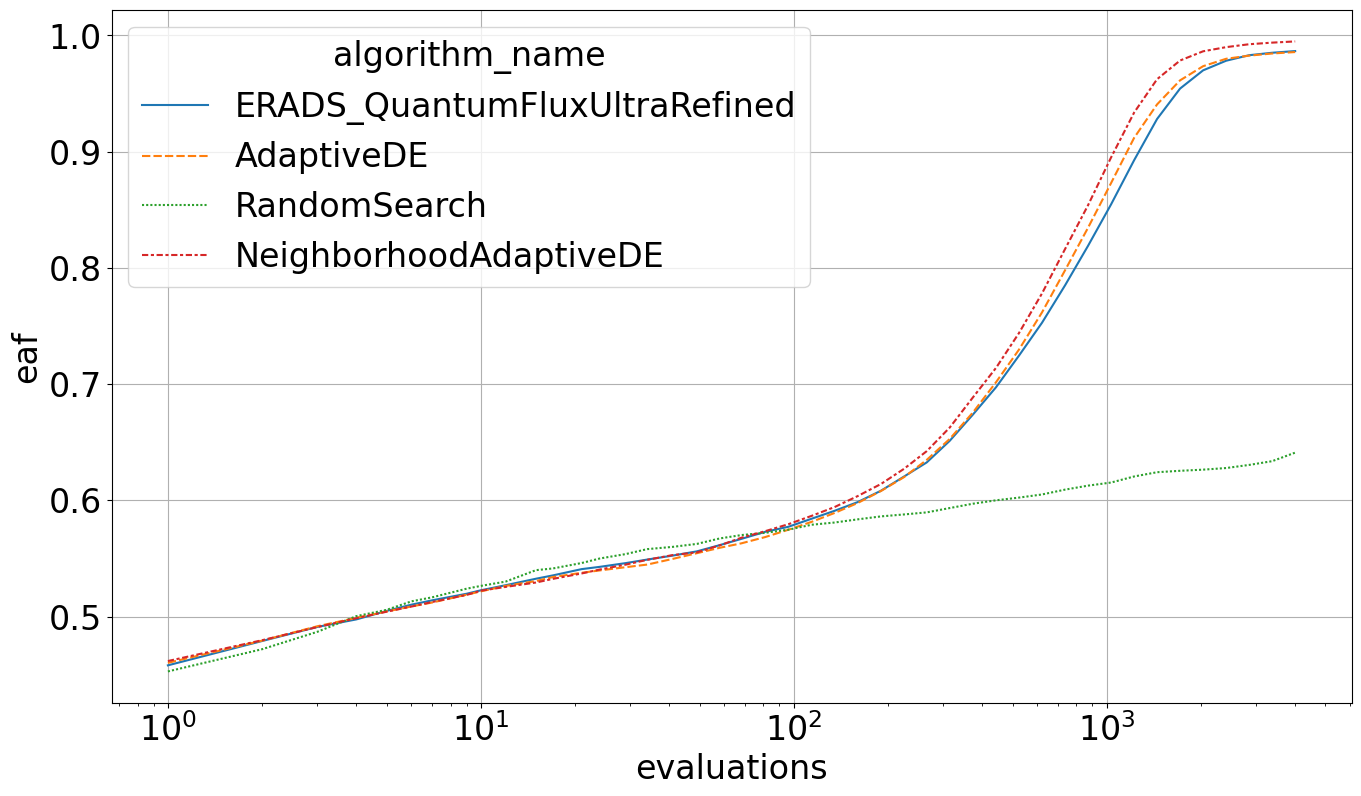

In [19]:
_ = iohinspector.plot.plot_ecdf(df.filter(pl.col("dimension") == 2), y_max=100, y_min=1e-8)

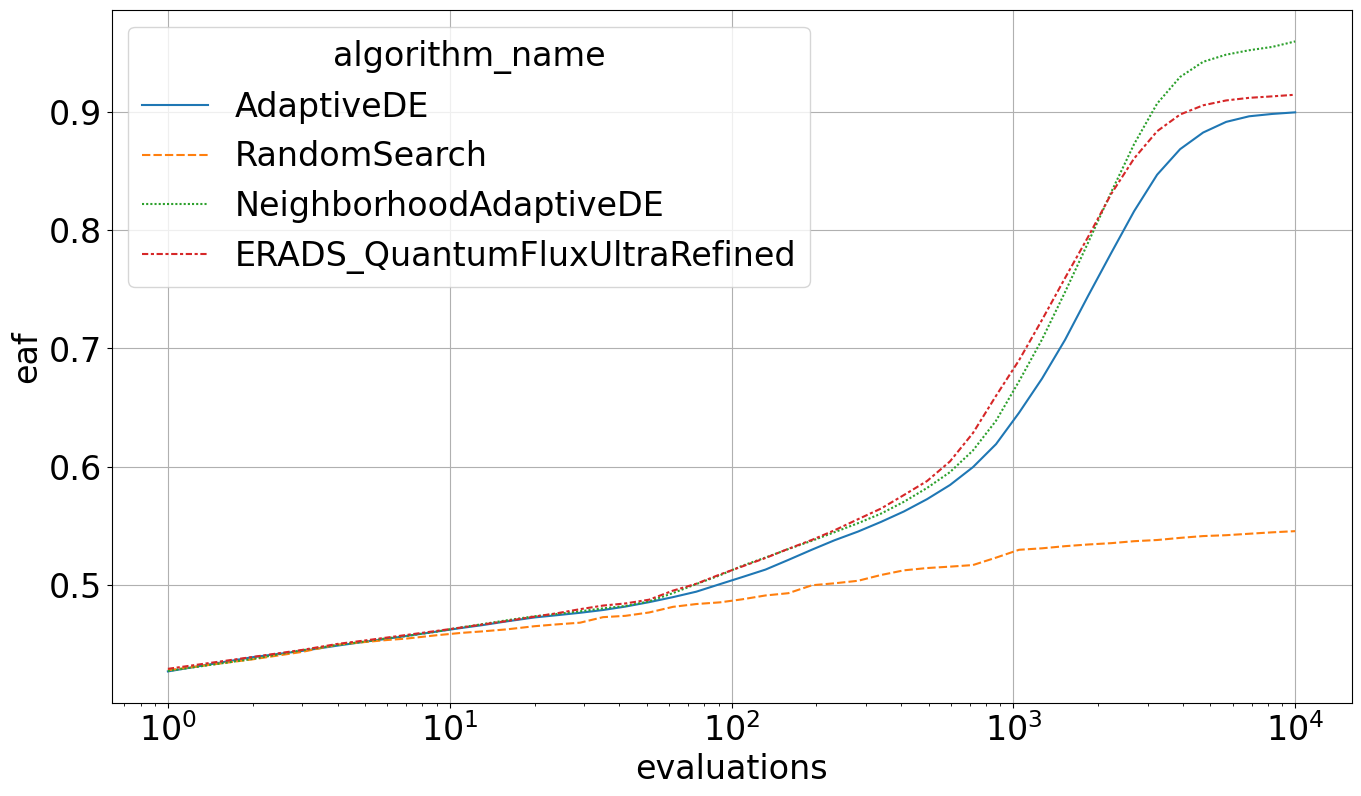

In [20]:
_ = iohinspector.plot.plot_ecdf(df.filter(pl.col("dimension") == 5), y_max=100, y_min=1e-8)

For the competition, the performance is judged based on the Area Over the Convergence Curve metric (which is equivalent to the area under the ECDF above). Specifically, we use bounds 10^2 and 10^-8. 

In [21]:
df_eaf = iohinspector.metrics.transform_fval(df, 1e-8, 1e2)
iohinspector.metrics.get_aocc(df_eaf.filter(pl.col("dimension") == 2), 4000, group_cols=['algorithm_name'])

algorithm_name,AOCC
str,f64
"""NeighborhoodAdaptiveDE""",0.866839
"""ERADS_QuantumFluxUltraRefined""",0.838459
"""RandomSearch""",0.393654
"""AdaptiveDE""",0.845977


In [22]:
iohinspector.metrics.get_aocc(df_eaf.filter(pl.col("dimension") == 5), 10000, group_cols=['algorithm_name'])

algorithm_name,AOCC
str,f64
"""RandomSearch""",0.259947
"""AdaptiveDE""",0.726089
"""NeighborhoodAdaptiveDE""",0.807771
"""ERADS_QuantumFluxUltraRefined""",0.766955


## Step 6: Comparing to baselines

For this competition, we provide a set of baseline algorithm data, which consist of 5 algorithms with 50 independent runs on each problem. This data can be loaded from https://doi.org/10.5281/zenodo.8208572 (`data.zip`) and incorporated into the IOHinspector analysis as usual. 

Note: since the baseline data contains a large amount of runs, processing it fully can take some time

In [61]:
manager_comp = iohinspector.DataManager()
manager_comp.add_folder("RS_Test")
manager_comp.add_folder("ERADS_QuantumFluxUltraRefined")
manager_comp.add_folder("MABBOB_Baselines")
manager_comp.add_folder("AdaptiveHybridDECMASMirroredDecay")
manager_comp.add_folder("AdaptiveDE_Ortho_CMA_Cauchy_StepSize")
manager_comp.add_folder("ADGSDE")

In [62]:
df = manager_comp.load(True, True, ['dimension', 'algorithm_name', 'instance'])
df_eaf = iohinspector.metrics.transform_fval(df, 1e-8, 1e2)
res_2d = iohinspector.metrics.get_aocc(df_eaf, 2*2000, group_cols=['algorithm_name'])
res_2d

algorithm_name,AOCC
str,f64
"""ADGSDE""",0.677951
"""PSS""",0.506898
"""RandomSearch""",0.320005
"""AdaptiveHybridDECMASMirroredDe…",0.631602
"""ERADS_QuantumFluxUltraRefined""",0.728243
"""AdaptiveDE_Ortho_CMA_Cauchy_St…",0.69079
"""ACA""",0.393659


In [63]:
res_5d = iohinspector.metrics.get_aocc(df_eaf, 5*2000, group_cols=['algorithm_name'])
res_5d

algorithm_name,AOCC
str,f64
"""AdaptiveHybridDECMASMirroredDe…",0.768579
"""ERADS_QuantumFluxUltraRefined""",0.837076
"""RandomSearch""",0.336434
"""ADGSDE""",0.79494
"""AdaptiveDE_Ortho_CMA_Cauchy_St…",0.814422
"""ACA""",0.418788
"""PSS""",0.558821


In [64]:
iohinspector.metrics.get_aocc(df_eaf.filter(pl.col("dimension") == 2), 4000, group_cols=['algorithm_name'])

algorithm_name,AOCC
str,f64
"""PSS""",0.60194
"""ERADS_QuantumFluxUltraRefined""",0.837459
"""RandomSearch""",0.393654
"""ACA""",0.482176
"""AdaptiveHybridDECMASMirroredDe…",0.785066
"""AdaptiveDE_Ortho_CMA_Cauchy_St…",0.823156
"""ADGSDE""",0.843398


In [65]:
iohinspector.metrics.get_aocc(df_eaf.filter(pl.col("dimension") == 5), 10000, group_cols=['algorithm_name'])

algorithm_name,AOCC
str,f64
"""PSS""",0.511605
"""RandomSearch""",0.259947
"""ACA""",0.327829
"""ADGSDE""",0.681573
"""AdaptiveDE_Ortho_CMA_Cauchy_St…",0.711613
"""AdaptiveHybridDECMASMirroredDe…",0.643158
"""ERADS_QuantumFluxUltraRefined""",0.752081
